# Satellite Cloud and Rain visual demo

*Running with flc_env on smiller2 machine*

**Libraries needed:**

In [1]:
#---Cloud search libraries
import s3fs #---The installation of this package on conda makes me nervous for the environment stability
import requests
import fnmatch

#---Accessory libraries
import datetime
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as feature

**Set the datetime to view:**

In [2]:
year = 2024
month = 1
day = 8
hour = 14

julian_day = datetime.datetime(year, month, day).strftime('%j')
print(julian_day)

datetime_str = str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+' '+str(hour).zfill(2)+'Z'
print(datetime_str)

008
2024-01-08 14Z


**Select region for visualization:**

In [3]:
#--- US CONUS region
latitude_north = 50
latitude_south = 24
longitude_west = -125
longitude_east = -66

**Connecting to AWS remote storage:**

In [4]:
fs = s3fs.S3FileSystem(anon=True)

**Search the AWS database:**

Abbreviations for ABI total precipitable water products:
* https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_level2_download.php

In [5]:
bucket = 'noaa-goes16'
product = 'ABI-L2-TPWF' #---Total precipitable water


data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

for f in files: 
    print(f)

noaa-goes16/ABI-L2-TPWF/2024/008/14/OR_ABI-L2-TPWF-M6_G16_s20240081400204_e20240081409512_c20240081411216.nc
noaa-goes16/ABI-L2-TPWF/2024/008/14/OR_ABI-L2-TPWF-M6_G16_s20240081410204_e20240081419512_c20240081421271.nc
noaa-goes16/ABI-L2-TPWF/2024/008/14/OR_ABI-L2-TPWF-M6_G16_s20240081420204_e20240081429512_c20240081431140.nc
noaa-goes16/ABI-L2-TPWF/2024/008/14/OR_ABI-L2-TPWF-M6_G16_s20240081430204_e20240081439512_c20240081441300.nc
noaa-goes16/ABI-L2-TPWF/2024/008/14/OR_ABI-L2-TPWF-M6_G16_s20240081440204_e20240081449512_c20240081451274.nc
noaa-goes16/ABI-L2-TPWF/2024/008/14/OR_ABI-L2-TPWF-M6_G16_s20240081450204_e20240081459512_c20240081501312.nc


In [6]:
#--- Using the top-of-the-hour
file = files[0]

In [7]:
resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file[12:])
if str(resp) != '<Response [200]>':
    print('file not found in AWS servers')

**Open the satellite data:**

In [8]:
nc = netCDF4.Dataset(file, memory = resp.content)
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))

**Get the latitudes and longitudes for the satellite image:**

In [9]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    #--- Added absolute to remove error
    r_s = (-b - np.sqrt(np.absolute(b**2 - 4*a*c)))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds



def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

In [10]:
ds_lat_lon = calc_latlon(ds)
((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_lat_lon, (latitude_south, latitude_north), (longitude_west, longitude_east))
region = ds_lat_lon.sel(x=slice(x1, x2), y=slice(y2, y1))


**Create the strings for the save file:**

In [11]:
date_str = str(datetime_str).replace('-', '_').replace(' ', '_')

**Plot the brightness-temperature difference:**

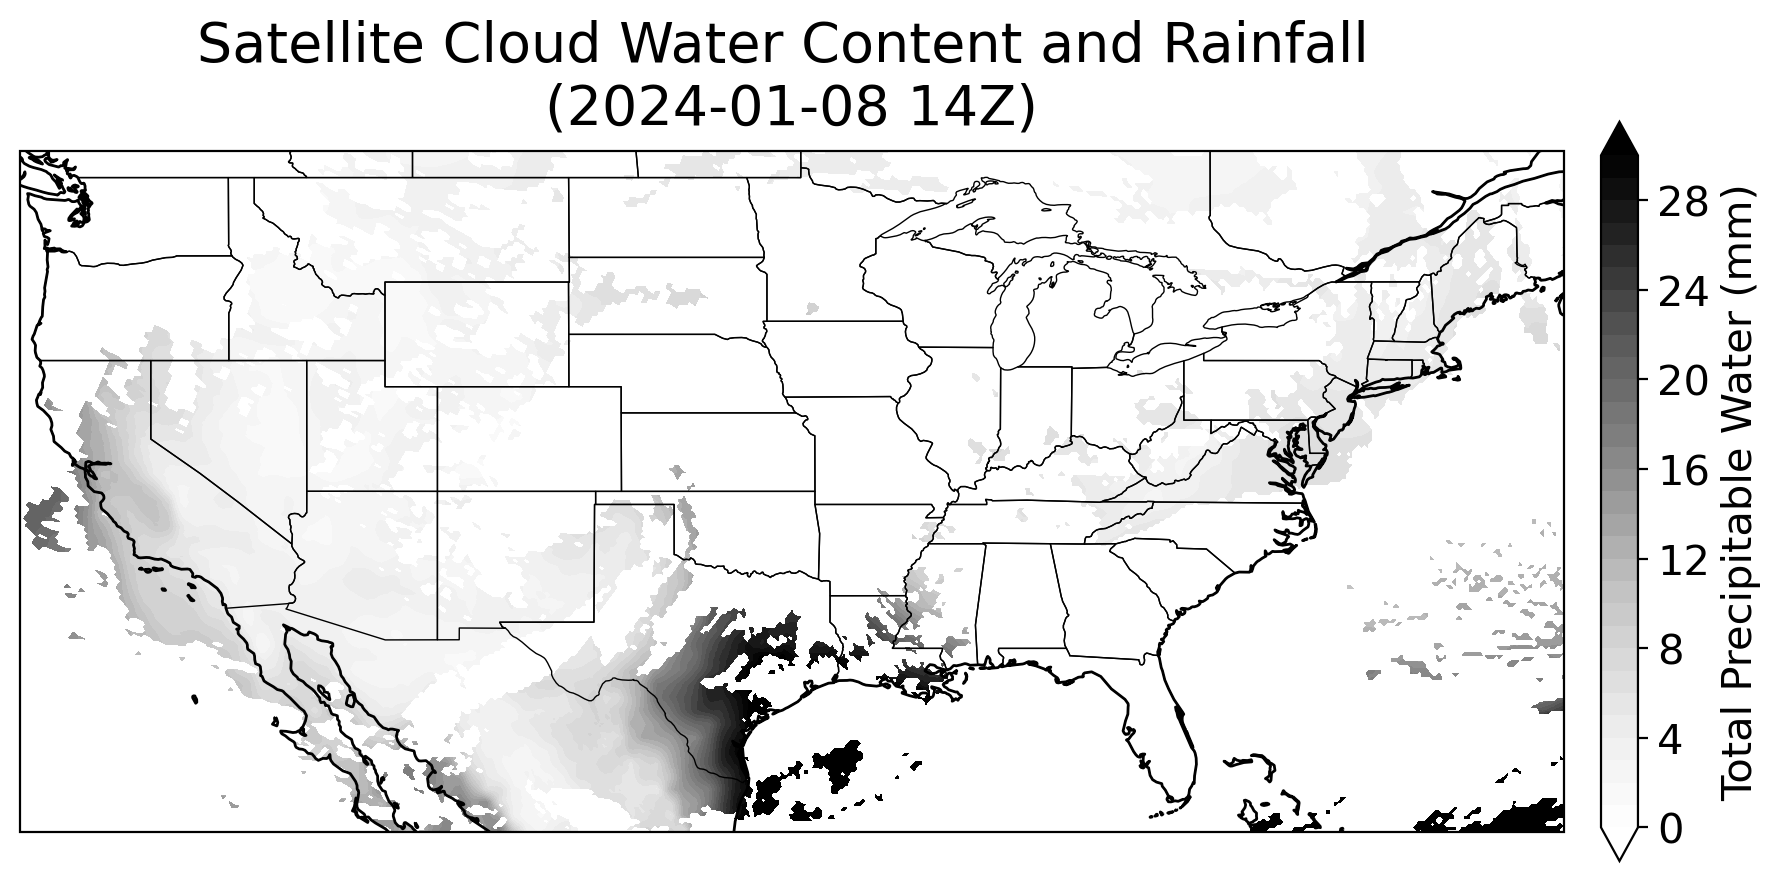

In [12]:

projection=ccrs.PlateCarree(central_longitude=0)

fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})


levels = np.linspace(0, 30, 31)
c=ax.contourf(ds_lat_lon.lon, ds_lat_lon.lat, ds_lat_lon.TPW, cmap='Greys', extend='both', levels=levels)


clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('Total Precipitable Water (mm)', fontsize=15)

ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("Satellite Cloud Water Content and Rainfall \n("+datetime_str+")", fontsize=20, pad=10)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(feature.STATES, zorder=100, edgecolor='#000', facecolor='none', linewidth=0.5)

fig.set_dpi(200)
fig.savefig("animation/cloud_rain_"+date_str, dpi=200, bbox_inches='tight')
fig.show()